In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.system("cp drive/MyDrive/data.zip .")
# os.system("unzip data.zip")

In [2]:
#import libraries
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cupy as cp
from keras.utils import np_utils
import copy

import contextlib


from scipy.sparse import csr_matrix, triu
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix
from scipy.sparse import identity
from sklearn.neighbors import NearestNeighbors

import scipy as sp   
from scipy.sparse.csgraph import johnson

import time

!pip install Munkres
from munkres import Munkres

# by using below command, gpu is available
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

dsetname = "unknown"

In [3]:
# Helpers
def get_custom_feat(data_dir):

    data = torch.load(data_dir)
    
    X = torch.cat([data['trainX'], data['testX']], 0)
    Y = torch.cat([data['trainY'], data['testY']], 0)

    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0],)

    # dataset = dict()
    # dataset['X']=X
    # dataset['Y']=Y

    # dataloader=DataLoader(TensorDataset(X,Y),batch_size=batch_size,shuffle=True,num_workers=4)

    meta = {'dim': X.shape[1], 'nClasses': int(max(Y).item())+1}

    return X, Y, X.shape[0], meta['dim'], meta['nClasses']


def get_custom_feat_npy(data_dir_X, data_dir_Y):

    X = torch.FloatTensor(np.load(data_dir_X))
    Y = torch.LongTensor(np.load(data_dir_Y))
    
    X = X.reshape(X.shape[0], -1)
    Y = Y.reshape(Y.shape[0],)

    # dataset = dict()
    # dataset['X']=X
    # dataset['Y']=Y

    # dataloader=DataLoader(TensorDataset(X,Y),batch_size=batch_size,shuffle=True,num_workers=4)

    meta = {'dim': X.shape[1], 'nClasses': int(max(Y).item())+1}

    return X, Y, X.shape[0], meta['dim'], meta['nClasses']

In [4]:
# # download mnist dataset from keras, then define training dataset X and its true labels Y
# from keras.datasets import mnist

# (X_tr, Y_tr), (X_tst, Y_tst) = mnist.load_data()

# (num_tr, depth, _) = X_tr.shape
# (num_tst, _, _) = X_tst.shape

# dim = depth**2

# X_tr = X_tr.reshape(num_tr, dim) # from 28*28 image to naive 784 dim feature vector 
# X_tst = X_tst.reshape(num_tst, dim)
# X = np.r_[X_tr, X_tst]
# print("Size of training dataset is", X.shape)
# X = X/255
# #X = (2*(X/255)) - 1

# Y = np.r_[Y_tr, Y_tst]
# Y = Y.reshape(1, Y.shape[0])

# C = 10 # the number of classes for MNIST

# # print(X.shape)
# # print(Y.shape)

# dsetname = "mnist"

In [5]:
# # Make Fshion Mnist dataset
# from torchvision.datasets import FashionMNIST

# def get_fashion(data_dir = './data/fashion/', batch_size=128, shuffle = True):

#     train = FashionMNIST(root = data_dir, train = True, download = True)
#     test = FashionMNIST(root = data_dir, train = False, download = True)

#     X=torch.cat([train.data.float().view(-1,784)/255.,test.data.float().view(-1,784)/255.],0)
#     Y=torch.cat([train.targets,test.targets],0)

#     meta = {'dim': 784, 'nClasses': 10}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']

# X, Y, _, dim, C = get_fashion()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "f-mnist"

In [6]:
# # Make 20news dataset

# from sklearn.datasets import fetch_20newsgroups, make_circles, make_moons, make_blobs, fetch_openml
# from sklearn.feature_extraction.text import TfidfVectorizer


# def get_20news():

#     data = fetch_20newsgroups(subset = 'all')
#     vectorizer = TfidfVectorizer(max_features = 2000, stop_words = 'english')

#     X = vectorizer.fit_transform(data.data).todense().astype(np.float32)
#     Y = data.target

#     n_samples = X.shape[0]
#     dim = X.shape[1]

#     Y = Y.reshape(1, n_samples)

#     n_classes = 20

#     return X, Y, n_samples, dim, n_classes

# X, Y, _, dim, C = get_20news()

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "20news"

In [7]:
# # Make Reuters10K dataset
# def get_reuters10K():
#     return get_custom_feat_npy('./IMSAT_datasets/all_dataset/reuters/10k_feature.npy', './IMSAT_datasets/all_dataset/reuters/10k_target.npy')

# X, Y, _, dim, C = get_reuters10K()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "reuters10k"

In [8]:
# # Make CIFAR10 dataset
# # Features extracted by Zhang following IMSAT paper
# def get_CIFAR10_zhang():
#     return get_custom_feat('./CIFAR10_feat/data.pkl')

# # Features provided with IMSAT code
# # Zhang cannot get reported performance with fixed eps; did not try for adaptive epsilon.
# def get_CIFAR10_IMSAT():

#     PATH = './IMSAT_datasets/all_dataset/cifar/'

#     y_train_ul = np.load(PATH+'train_labels.npy').astype(np.int32)
#     y_test = np.load(PATH+'test_labels.npy').astype(np.int32)
#     y_whole = np.concatenate((y_train_ul, y_test), axis = 0)
#     x_whole = np.load(PATH+'resnet.npz')['arr_0']

#     X = torch.Tensor(x_whole).reshape(x_whole.shape[0], -1)
#     Y = torch.LongTensor(y_whole).reshape(y_whole.shape[0])

#     meta = {'dim': X.shape[1], 'nClasses': 10}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']

# X, Y, _, dim, C = get_CIFAR10_IMSAT()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "cifar10"

In [9]:
# # Make CIFAR100 dataset
# # Features extracted by Zhang following IMSAT paper
# def get_CIFAR100_zhang():
#     return get_custom_feat('./CIFAR100_feat/data.pkl')

# # Features provided with IMSAT code
# def get_CIFAR100_IMSAT():

#     PATH = './IMSAT_datasets/all_dataset/cifar100/'

#     y_whole = np.load(PATH + 'y.npy')
#     x_whole = np.load(PATH+'resnet.npz')['arr_0']

#     X = torch.Tensor(x_whole).reshape(x_whole.shape[0], -1)
#     Y = torch.LongTensor(y_whole).reshape(y_whole.shape[0])

#     meta = {'dim': X.shape[1], 'nClasses': 100}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']


# X, Y, _, dim, C = get_CIFAR100_IMSAT()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "cifar100"

In [10]:
# # Make SVHN dataset
# def get_svhn():
    
#     PATH = './IMSAT_datasets/all_dataset/svhn/'

#     x_train_ul = np.load(PATH+'train_feature.npy').astype(np.float32)
#     x_test = np.load(PATH+'test_feature.npy').astype(np.float32)
#     y_train_ul = np.load(PATH+'train_target.npy').astype(np.int32)
#     y_test = np.load(PATH+'test_target.npy').astype(np.int32)

#     x_whole = np.concatenate((x_train_ul, x_test), axis = 0)
#     y_whole = np.concatenate((y_train_ul, y_test), axis = 0)

#     X = torch.Tensor(x_whole).reshape(x_whole.shape[0], -1)
#     Y = torch.LongTensor(y_whole).reshape(y_whole.shape[0])

#     meta = {'dim': X.shape[1], 'nClasses': int(max(Y).item())+1}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']


# X, Y, _, dim, C = get_svhn()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "svhn"

In [11]:
# # Make Omniglot dataset
# def get_omniglot():
    
#     PATH = './IMSAT_datasets/all_dataset/omniglot/'
#     scale=   1.0 / 255.0
#     shift= - 0.0

#     augmented_data = (np.load(PATH+"augmented_omniglot_downsampled5_data.npz")['arr_0']).astype(np.float32)*scale + shift
#     augmented_target = np.load(PATH+"augmented_omniglot_downsampled5_target.npz")['arr_0']

#     X = torch.Tensor(augmented_data).reshape(augmented_data.shape[0], -1)
#     Y = torch.LongTensor(augmented_target).reshape(augmented_target.shape[0])

#     meta = {'dim': X.shape[1], 'nClasses': int(max(Y).item())+1}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']

# X, Y, _, dim, C = get_omniglot()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "omniglot"

In [12]:
# # Make STL dataset

# def get_imsat_stl10(batch_size=128):

#     PATH = './IMSAT_datasets/all_dataset/stl/'
#     label = np.fromfile(PATH+'train_y.bin', dtype=np.uint8)
#     test_label = np.fromfile(PATH+'test_y.bin', dtype=np.uint8)
#     y_whole = (np.concatenate((label, test_label), axis = 0) - 1).astype(np.int32)
#     x_whole = np.load(PATH + 'resnet.npz')['arr_0']
#     X = torch.Tensor(x_whole).reshape(x_whole.shape[0], -1)
#     Y = torch.LongTensor(y_whole).reshape(y_whole.shape[0])
#     meta = {'dim': X.shape[1], 'nClasses': 10}

#     return X, Y, X.shape[0], meta['dim'], meta['nClasses']

# X, Y, _, dim, C = get_imsat_stl10()

# X = X.detach().cpu().numpy()
# Y = Y.detach().cpu().numpy()
# Y = Y.reshape(1,Y.shape[0])

# print(dim)
# print(C)
# print(X.shape[0])

# dsetname = "stl"

In [13]:
# # Make Two-Moons
# from sklearn.datasets import make_moons

# X, Y = make_moons(n_samples=5000,
#                   shuffle = None,
#                   noise = 0.05,
#                   random_state = True,)
# Y = Y.reshape(1,Y.shape[0])
# dim = 2
# C = 2

# print(X)
# print(Y)

# dsetname = "Two-Moons"

# #Visualization for Two-Moons

# import matplotlib.pyplot as plt
# import pandas as pd


# # Visualization
# frame = pd.DataFrame(X)
# frame['cluster'] = Y[0]
# frame.columns = ['y-var', 'x-var', 'cluster']
# color=['red','blue']
# for j in range(0,C):
#     data = frame[frame["cluster"]==j]
#     plt.scatter(data["y-var"],data["x-var"],c=color[j],s=1)
# plt.show()
# print("Visualization is finished.")

[[ 1.01624345 -0.00611756]
 [ 0.99471512 -0.00821641]
 [ 1.00864144 -0.01798886]
 ...
 [ 0.39427631 -0.00228631]
 [ 0.40488597 -0.01215205]
 [ 0.39937177 -0.01538401]]
[[0 0 0 ... 1 1 1]]


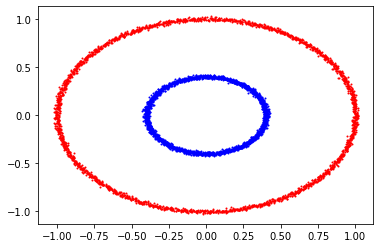

Visualization is finished.


In [14]:
# Make Two-Rings
from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=5000,
                  shuffle = None,
                  noise = 0.01,
                  random_state=True,
                  factor = 0.4)

Y = Y.reshape(1,Y.shape[0])
dim = 2
C = 2

print(X)
print(Y)

dsetname = "Two-Rings"

#Visualization for Two-Moons

import matplotlib.pyplot as plt
import pandas as pd


# Visualization
frame = pd.DataFrame(X)
frame['cluster'] = Y[0]
frame.columns = ['y-var', 'x-var', 'cluster']
color=['red','blue']
for j in range(0,C):
    data = frame[frame["cluster"]==j]
    plt.scatter(data["y-var"],data["x-var"],c=color[j],s=1)
plt.show()
print("Visualization is finished.")

In [15]:
def Knn2Adj(idx, k):

    n = idx.shape[0]

    idx_i = np.array(range(n))
    idx_i = np.tile(idx_i, (k+1,1)).transpose().reshape(1, n*(k+1))[0]
    idx_j = idx.reshape(1, n*(k+1))[0]

    adj = csc_matrix((np.ones(n*(k+1)),(idx_i,idx_j)), shape=(n,n)).astype(float)
    e = identity(n)
    adj = adj - e
    adj = adj + adj.transpose() - adj.multiply(adj.transpose())

    del idx_i, idx_j, e

    return adj



def build_gnng(K_g, indices):
    KnnIDXwithKg = indices[:,0:K_g+1]
    A = Knn2Adj(KnnIDXwithKg, K_g)

    start = time.time()
    # geodesic_dist = csc_matrix(sp.sparse.csgraph.johnson(A))
    g_distances = sp.sparse.csgraph.johnson(A)
    del A
    g_distances = np.where( (g_distances==np.inf) | (g_distances==0), 0, g_distances) 
    m = np.min(np.count_nonzero(g_distances, axis=1))
    n = g_distances.shape[1]
    g_indices = np.argsort(g_distances, axis=0)
    #g_indices = g_indices[:,n-K_g:n]
    g_indices = g_indices[:,n-m:n]
    g_distances = csc_matrix(g_distances)
    #del geodesic_dist
    #geodesic_dist = np.where(geodesic_dist>0, 1, geodesic_dist)
    #geodesic_nng = geodesic_dist.nonzero()
    end = time.time()
    print(f"{end-start} seconds by computing geodesic distance.")

    return g_distances, g_indices


def conditional_entropy(soft):
    loss = torch.sum(-soft*torch.log(soft + 1e-8)) / soft.shape[0]
    return loss


def entropy(soft):
    avg_soft = torch.mean(soft, 0, True) 
    loss = -torch.sum(avg_soft * torch.log(avg_soft + 1e-8))
    return loss


def kl(p, q):
    loss = torch.sum(p * torch.log((p + 1e-8) / (q + 1e-8))) / p.shape[0]
    return loss






@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


def return_vat_Loss(model, x, xi, eps):

    optimizer.zero_grad()
    
    with _disable_tracking_bn_stats(model):
        with torch.no_grad():
            target = torch.softmax(model(x), 1) 
        
        d = torch.randn(x.shape).to(dev)
        d = _l2_normalize(d)
        d.requires_grad_()
        out_vadv = model(x + xi*d)
        hat = torch.softmax(out_vadv, 1)
        adv_distance = kl(target, hat)

        adv_distance.backward()
        
        d = _l2_normalize(d.grad)
        r_adv = eps * d
        out_vadv = model(x + r_adv)
        hat = torch.softmax(out_vadv, 1)
        R_vat = kl(target, hat)

    return R_vat




# ## upper-bound of I_nce
# def SiameseLoss(model, soft_out1, x_agm, t1, alpha):

#     m = soft_out1.shape[0]
#     a = csr_matrix(np.ones((m,m)))
   
#     idx_i, idx_j = a.nonzero()
#     del a

     
#     with _disable_tracking_bn_stats(model):
#         soft_out2 = torch.softmax(model(x_agm), 1)

#         ip = soft_out1[idx_i,:] * soft_out2[idx_j,:]
#         ip = torch.sum(ip, 1).reshape(m,m)

#         if alpha==0:
#           critic = torch.log( 1 + t1*(ip - 1) )

#         if alpha==1:
#           critic = t1 * ip
          
#         if alpha==2:
#           critic = -torch.log( 1 + t1*(1-ip) )

#         lp = torch.mean(torch.diag(critic,0)) 
#         ln = -torch.sum(torch.tril(critic,-1) + torch.triu(critic,1)) /(m*(m-1))
#         l_s = (1 - (1/m))*(lp + ln)

#     return l_s, soft_out2





# ## exact I_nce
# def SiameseLoss(model, soft_out1, x_agm, t1, alpha):

#     m = soft_out1.shape[0]
#     a = csr_matrix(np.ones((m,m)))
   
#     idx_i, idx_j = a.nonzero()
#     del a

     
#     with _disable_tracking_bn_stats(model):
#         soft_out2 = torch.softmax(model(x_agm), 1)

#         ip = soft_out1[idx_i,:] * soft_out2[idx_j,:]
#         ip = torch.sum(ip, 1).reshape(m,m)

#         if alpha==0:
#           critic = torch.log( 1 + t1*(ip - 1) )

#         if alpha==1:
#           critic = t1 * ip
          
#         if alpha==2:
#           critic = -torch.log( 1 + t1*(1-ip) )


#         I_nce = np.log(m) + torch.mean( torch.log( torch.diag( torch.softmax(critic,1),0 ) ) )

#         l_s = I_nce

#     return l_s, soft_out2



## symmetrized I_nce
def SiameseLoss(model, soft_out1, x_agm, t1, alpha):

    m = soft_out1.shape[0]
    a = csr_matrix(np.ones((m,m)))
   
    idx_i, idx_j = a.nonzero()
    del a

     
    with _disable_tracking_bn_stats(model):
        soft_out2 = torch.softmax(model(x_agm), 1)

        ip = soft_out1[idx_i,:] * soft_out2[idx_j,:]
        ip = torch.sum(ip, 1).reshape(m,m)

        if alpha==0:
          critic = torch.log( 1 + t1*(ip - 1) )

        if alpha==1:
          critic = t1 * ip
          
        if alpha==2:
          critic = -torch.log( 1 + t1*(1-ip) )
        

        I_nce1 = np.log(m) + torch.mean( torch.log( torch.diag( torch.softmax(critic,1),0 ) ) )
        I_nce0 = np.log(m) + torch.mean( torch.log( torch.diag( torch.softmax(critic,0),0 ) ) )


        l_s = (I_nce1 + I_nce0) / 2

    return l_s, soft_out2







def ReturnACC(cluster, target_cluster, k):
    """ Compute error between cluster and target cluster
    :param cluster: proposed cluster
    :param target_cluster: target cluster
    k: number of classes
    :return: error
    """
    n = np.shape(target_cluster)[0]
    M = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            M[i][j] = np.sum(np.logical_and(cluster == i, target_cluster == j))
    m = Munkres()
    indexes = m.compute(-M)
    corresp = []
    for i in range(k):
        corresp.append(indexes[i][1])
    pred_corresp = [corresp[int(predicted)] for predicted in cluster]
    acc = np.sum(pred_corresp == target_cluster) / float(len(target_cluster))
    return acc 



def get_agm(x, idx_itr, knn_idx):
    knn_idx_itr = knn_idx[idx_itr,:]
    for i in range(knn_idx_itr.shape[0]):
      v = np.random.permutation(knn_idx_itr[i,:])
      knn_idx_itr[i,:] = v

    v = np.random.choice(list(range(knn_idx_itr.shape[1])), size=1, replace=False)
    idx0 = knn_idx_itr[:,v[0]]
    x_agm0 = x[idx0,:]
    
    return x_agm0, idx0

In [16]:
import os

start = time.time()

alpha_vat = 0.25
K = 15 # Number of neighbors for constructing knn graph


knncachestr = "%s-k%d.npy" % (dsetname, K+1)

if dsetname != "unknown" and os.path.exists(knncachestr):
  
  print("Loaded cached kNN from %s" % knncachestr)
  distances = np.load(knncachestr)
  indices = np.load("i" + knncachestr)

else:

  nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='brute').fit(X)
  distances, indices = nbrs.kneighbors(X)
  np.save(knncachestr, distances)
  np.save("i" + knncachestr, indices)

K_vat = 10
R = alpha_vat*distances[:,K_vat]
R = R.reshape(X.shape[0],1)


end = time.time()
print(f"{end-start} seconds by Brute-Force KNN.")


R = torch.tensor(R.astype('f')).to(dev)
X = torch.tensor(X.astype('f')).to(dev) # this unlabeled dataset (set of feature vectors) is input



# how many neighbors should be used to define geodesic metric, K_g =< K
# two rings -> Kg=15
K_g = K

# build geodesically nearest neighbor graph, i.e., returns goeodic_distances and geodesic indices are returned
_, g_indices = build_gnng(K_g, indices)

Loaded cached kNN from Two-Rings-k16.npy
0.003136873245239258 seconds by Brute-Force KNN.
5.850985765457153 seconds by computing geodesic distance.


In [17]:
# define archtechture of MLP(Multi Layer Perceptron). 
# in this net, batch-normalization (bn) is used. 
# bn is very important to stabilize the training of net. 
#torch.manual_seed(0)
class Net(nn.Module): 

    def __init__(self):
        super(Net, self).__init__()

        self.l1 = nn.Linear(dim, 1200)
        self.bn1 = nn.BatchNorm1d(1200)

        self.l2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)

        self.l3 = nn.Linear(1200,C)

        
    def forward(self, x):
       
        x = F.relu(self.bn1(self.l1(x)))
        x = F.relu(self.bn2(self.l2(x)))
        x = self.l3(x)
        
        return x




net = Net()

# throw net object to gpu
net = net.to(dev)


################################################## Training of imsat ############################################

# decide hyperparameter values for imsat training
epochs = 50 # number of epochs


## hyperparameter in VAT
## xi = 10^{1} for high-dimensional real world datasets
## xi = 10^{-1} for two rings and two moons
xi = 10**(-1)       

mini_size = 250 # size of mini-batch training dataset

m = X.shape[0]//mini_size # number of iteration at each epoch 



##two-rings -> mu=0.1, gamma =16.5, eta=10
##real world -> mu=0.045, gamma=15, eta=5
mu = 0.1
gamma = 16.5
eta = 10





## define optimizer for set of parameters in deep neural network
## lr is the learning rate of parameter vector, betas are the lr of gradient and second moment of gradient
optimizer = optim.Adam(net.parameters(), 
                        lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


tau = 0.05

alpha = 1 ## alpha-exp family -> choose alpha = 0 or 1 or 2


# #should be smaller than K=200, here we define T(x) for each x, K0 = 5, 7, 15, 100, 200(=K)
# #mnist, svhn, stl, omniglot, cifar100 -> K0=7
# #reuters10k -> K0=50
# #20news -> K0=200
# #cifar10 -> K0=15
# K0 = 7 ## -> used only for real world datasets

## 20news, reuters10K -> beta=4/5,
## The real-world others -> beta=0
## two rings -> 6/10
## two-moons -> 1/2
beta = 6/10





print("Start training of SIM_agm.")
for epoch in range(epochs):
    print("At ", epoch, "-th epoch, ")

    # set empiricial loss to 0 in the beginning of epoch
    empirical_objective_loss = 0.0

    idx_eph = np.random.permutation(X.shape[0])
    
    net.train()

    for itr in range(m):
      
      ## chose a core idx of mini_batch
      idx_itr = idx_eph[itr*mini_size:(itr+1)*mini_size]

      # define components at each iteration
      X_itr = X[idx_itr,:]


      # ########################## knn based transformation function related part ##############
      # if beta == 0:
      #   X_agm1_itr, idx_agm1_itr = get_agm(X, idx_itr, indices[:,1:K0+1]) #except 20news reuters10k
      # else:
      #   X_agm1_itr, idx_agm1_itr = get_agm(X, idx_itr, indices[:,int(beta*K0):K0+1]) #20news or reuters10k

      

      ########################## geodesic based transformation function related part ##############
      lgth = g_indices.shape[1]
      if beta == 0:
        X_agm1_itr, idx_agm1_itr = get_agm(X, idx_itr, g_indices[:,1:lgth]) 
      else:
        X_agm1_itr, idx_agm1_itr = get_agm(X, idx_itr, g_indices[:,int(beta*lgth):lgth])



      #################### VAT loss ################
      l_vat = return_vat_Loss(net, X_itr, xi, R[idx_itr,:])
      l_vat1 = return_vat_Loss(net, X_agm1_itr, xi, R[idx_agm1_itr,:])



      soft_out_itr = torch.softmax(net(X_itr) , 1)
  


      ####################### Siamese loss (or I_nce) related part ###########
      ## define positive and negative loss, where tau is a fixed value
      l_s, soft_out_agm1_itr = SiameseLoss(net, soft_out_itr, X_agm1_itr, tau, alpha)
      


      ######################## I(X;Y) related part #######################
      ## define entropy of y
      ent_y = entropy(torch.cat((soft_out_itr, soft_out_agm1_itr),0))
      

      ## define shannon conditional entropy loss H(p(y|x)) named by c_ent.
      c_ent = conditional_entropy(torch.cat((soft_out_itr, soft_out_agm1_itr),0))
      


      ######################### our objective defined ##################        
      # objective of sim
      objective = ((l_vat + l_vat1)/2) - mu*(  (eta*ent_y - c_ent) + gamma*( l_s )  )




      # update the set of parameters in deep neural network by minimizing loss
      optimizer.zero_grad() 
      objective.backward()
      optimizer.step()


      empirical_objective_loss = empirical_objective_loss + objective.data




    # #empirical_loss = running_loss/m
    empirical_objective_loss = empirical_objective_loss.cpu().numpy()
    print("average empirical objective loss is", empirical_objective_loss/m, ',')


    net.eval()

    # at each epoch, prediction accuracy is displayed
    with torch.no_grad():
        out = net(X)
        preds = torch.argmax(out, dim=1)
        preds = preds.cpu().numpy()
        preds = preds.reshape(1, preds.shape[0])
        clustering_acc = ReturnACC(preds[0], Y[0], C)
    print("and current clustering accuracy is", clustering_acc )

Start training of SIM_agm.
At  0 -th epoch, 
average empirical objective loss is -0.693436861038208 ,
and current clustering accuracy is 0.7854
At  1 -th epoch, 
average empirical objective loss is -0.7092516422271729 ,
and current clustering accuracy is 1.0
At  2 -th epoch, 
average empirical objective loss is -0.7310489654541016 ,
and current clustering accuracy is 1.0
At  3 -th epoch, 
average empirical objective loss is -0.7309874057769775 ,
and current clustering accuracy is 1.0
At  4 -th epoch, 
average empirical objective loss is -0.730995512008667 ,
and current clustering accuracy is 1.0
At  5 -th epoch, 
average empirical objective loss is -0.7323568344116211 ,
and current clustering accuracy is 1.0
At  6 -th epoch, 
average empirical objective loss is -0.7303846836090088 ,
and current clustering accuracy is 1.0
At  7 -th epoch, 
average empirical objective loss is -0.7319003105163574 ,
and current clustering accuracy is 1.0
At  8 -th epoch, 
average empirical objective loss i

In [18]:
# #UMAP Visualization of IMSAT for MNIST

# net.eval()

# with torch.no_grad():
#     x_embedded = net(X)
#     x_embedded = x_embedded.cpu().numpy()

# # from umap import UMAP
# !pip install umap-learn scikit-learn
# import umap
# import matplotlib.pyplot as plt
# import pandas as pd

# #UMAP
# start = time.time()
# umap_projector = umap.UMAP(n_neighbors=10, n_components=2)
# x_umap = umap_projector.fit_transform(x_embedded)
# print("UMAP is finished.")
# end = time.time()
# print(f"{end-start} seconds by UMAP.")

# # Visualization
# frame = pd.DataFrame(x_umap)
# frame['cluster'] = Y[0]
# frame.columns = ['y-var', 'x-var', 'cluster']
# color=['red','orange','yellow','cyan','green','lightblue','blue','purple','grey','black']
# for k in range(0,10):
#     data = frame[frame["cluster"]==k]
#     plt.scatter(data["y-var"],data["x-var"],c=color[k],s=0.05)
# plt.show()
# print("Visualization is finished.")

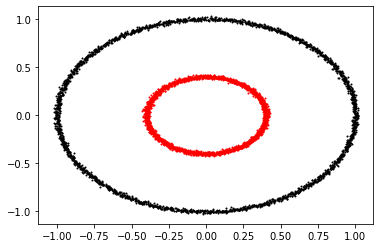

Visualization is finished.


In [19]:
#Visualization after IMSAT for Two-Moons or Two-Rings ver.2 

import matplotlib.pyplot as plt
import pandas as pd


# Visualization
frame = pd.DataFrame(X)
frame['cluster'] = preds[0]
frame.columns = ['y-var', 'x-var', 'cluster']
color=['red','black']
for j in range(0,C):
    data = frame[frame["cluster"]==j]
    plt.scatter(data["y-var"],data["x-var"],c=color[j],s=1)
plt.show()
print("Visualization is finished.")